In [2]:
import tensorflow as tf
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Embedding
from keras.engine.topology import Input
from keras.layers import MaxPooling1D,GlobalMaxPooling1D,Conv1D,Dense,Dropout,regularizers,GlobalAveragePooling1D
from keras.models import Model,load_model
from keras import optimizers
import h5py # necessary for saving keras model
import numpy as np
import pickle
from keras.models import Sequential
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

/Applications/anaconda/envs/dlnd-tf-lab/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
from keras.layers import Concatenate,GaussianNoise

In [3]:
# first we need to download glove.6B according to README
# load pretrained word embeddings:glove.6B.100d.txt

filename = 'glove.6B.100d.txt' ## this file 'glove.6B.100d.txt' is composed of lines with each line containning a word and its embedding.

## store words and their embeddings in separate lists, then turn embedding list to np array.

def loadGloVe(filename):
    vocab = []
    embd = []
    #with open (filename,'r') as f:
        #emb_size = len(f.readline().strip().split(' '))-1
    #vocab.append('unk') #load unknown words
    #embd.append([0]*emb_size)
    
    file = open(filename,'r')
    for line in file:
        row = line.strip().split(' ')
        vocab.append(row[0])
        embd.append(row[1:])
    print('Loaded GloVe!')
    file.close()
    return vocab,embd

vocab,embd = loadGloVe(filename)
vocab_size = len(vocab)
embedding_dim = len(embd[0])
embedding = np.asarray(embd)

Loaded GloVe!


In [7]:
# load preprocessed data before vecortization
with open("Preprocessed data for CNN - update.txt",'rb') as f:
    texts_train_ls = pickle.load(f)
    texts_test_ls = pickle.load(f)
    labels_train = pickle.load(f)
    labels_test = pickle.load(f)
print (len(texts_train_ls))
print (len(texts_test_ls))
print (len(labels_train))
print (len(labels_test)) 

11314
7532
11314
7532


In [8]:
# build vocabulary of the text; elementary vectorization.
num_words = 20000
max_length = 300

tokenizer = Tokenizer(num_words = num_words)
tokenizer.fit_on_texts (texts_train_ls)
sequences_train = tokenizer.texts_to_sequences(texts_train_ls)
sequences_test = tokenizer.texts_to_sequences(texts_test_ls)

data_train = pad_sequences(sequences_train,maxlen = max_length)
data_test = pad_sequences(sequences_test,maxlen = max_length)

word_index = tokenizer.word_index
print (len(word_index.items()))

133927


In [9]:
targets_train = to_categorical(labels_train)
targets_test = to_categorical(labels_test)

In [10]:
# build embedding matrix
embedding_matrix = np.zeros((num_words+1,embedding_dim))

for word,index in word_index.items(): # word_index start with index one, not zero.
    if index > num_words:
        continue
    if word not in vocab:
        continue
    else:
        embedding_matrix[index] = embedding[vocab.index(word)]

In [11]:
# build embedding layer
embedding_layer = Embedding(num_words+1,embedding_dim,weights = [embedding_matrix],input_length = data_train.shape[1],trainable = False)

In [12]:
# vectorization
sequence_input = Input(shape = (data_train.shape[1],),dtype = 'int32')
embedded_input = embedding_layer(sequence_input)
model_pre = Model(sequence_input,embedded_input)

embedded_data_train = model_pre.predict(data_train)
embedded_data_test = model_pre.predict(data_test)

In [13]:
X_test_1 = embedded_data_test[:int(len(embedded_data_test)*0.4)]
X_test_2 = embedded_data_test[int(len(embedded_data_test)*0.4):]

y_test_1 = targets_test[:int(len(embedded_data_test)*0.4)]
y_test_2 = targets_test[int(len(embedded_data_test)*0.4):]

In [14]:
# split the original train set into a new train set and a validation set
X_train,X_val,y_train,y_val = train_test_split(embedded_data_train,targets_train,test_size = 0.2,random_state = 42)

In [15]:
with open("embedded_dataset_20000_300_TextCNN.txt",'wb') as f:
    pickle.dump(X_train,f)
    pickle.dump(X_val,f)
    pickle.dump(y_train,f)
    pickle.dump(y_val,f)
    
    pickle.dump(X_test_1,f)
    pickle.dump(X_test_2,f)
    pickle.dump(y_test_1,f)
    pickle.dump(y_test_2,f)

## Check point. Load the embedded train set

In [9]:
with open("embedded_dataset_20000_300_TextCNN.txt",'rb') as f:
    X_train = pickle.load(f)
    X_val = pickle.load(f)
    y_train = pickle.load(f)
    y_val = pickle.load(f)
   
    X_test_1 = pickle.load(f)
    X_test_2 = pickle.load(f)
    y_test_1 = pickle.load(f)
    y_test_2 = pickle.load(f)

In [6]:
X_train.shape

(9051, 300, 100)

In [7]:
def draw_performance(history_list,n_epochs_per_hs):
# history_list: list of histories
# n_epochs_per_hs: the number of epochs per history
    
    plt.style.use("ggplot")
    
    hs_keys = list(history_list[0].history.keys())
    labels = hs_keys
    clr = ['r','orange','green','b']
    fig = plt.figure(figsize = (16,9))
    n_epochs = n_epochs_per_hs * len(history_list)

    for i in range(len(history_list)):
        for j,key in enumerate(hs_keys): 
            plt.plot(range(i*n_epochs_per_hs,(i+1)*n_epochs_per_hs),history_list[i].history[key],clr[j])
    plt.legend(labels)
    plt.grid(True,linestyle = "-",color = 'k',linewidth = 0.1)
    plt.xticks(np.arange(0,n_epochs,10))
    plt.yticks(np.arange(0,3,0.1))
    
    plt.show()

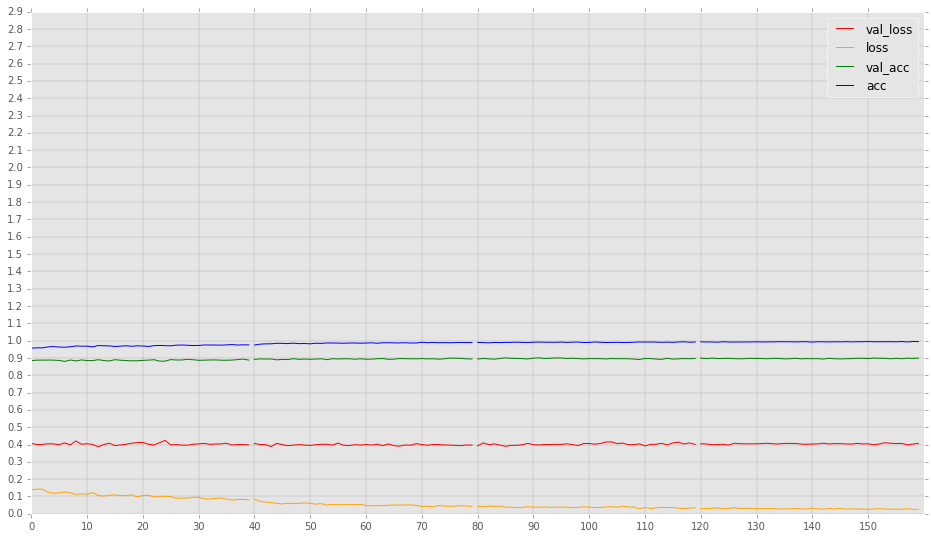

In [17]:
# The following graph shows performance of the final model
history_list = [hs_11_2,hs_11_3,hs_11_4,hs_11_5]
n_epochs_per_hs = 40

draw_performance(history_list,n_epochs_per_hs)

## Original Model

In [41]:
# first TextCNN model
input_x = Input(shape = (X_train.shape[1],X_train.shape[2]),dtype = 'float32')

x1 = Conv1D(64,3,activation = 'relu')(input_x)#,kernel_regularizer = regularizers.l2(0.01)
x1 = Dropout(0.5)(x1)
x2 = Conv1D(64,5,activation = 'relu')(input_x)#,kernel_regularizer = regularizers.l2(0.01)
x2 = Dropout(0.5)(x2)
x3 = Conv1D(64,7,activation = 'relu')(input_x)#,kernel_regularizer = regularizers.l2(0.01)
x3 = Dropout(0.5)(x3)

x1 = GlobalMaxPooling1D()(x1)# 64 dim vector
x2 = GlobalMaxPooling1D()(x2) # 64 dim vector
x3 = GlobalMaxPooling1D()(x3) # 64 dim vector

x = Concatenate(axis=-1)([x1,x2,x3])
x = Dropout(0.5)(x)

preds = Dense(y_train.shape[1], activation='softmax')(x)#,kernel_regularizer = regularizers.l2(0.01)

model = Model(input_x,preds)
optimizer = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None)#'rmsprop', decay=0.1
model.compile(loss = 'categorical_crossentropy',optimizer=optimizer,metrics=['acc'])


model.fit(X_train,y_train,batch_size = 128,epochs = 40,validation_data=(X_val, y_val)) #8652


Train on 9051 samples, validate on 2263 samples
Epoch 1/40
9051/9051 [==============================] - 37s 4ms/step - loss: 3.6968 - acc: 0.1558 - val_loss: 2.1952 - val_acc: 0.4848
Epoch 2/40
9051/9051 [==============================] - 38s 4ms/step - loss: 2.0077 - acc: 0.3868 - val_loss: 1.7329 - val_acc: 0.6310
Epoch 3/40
9051/9051 [==============================] - 37s 4ms/step - loss: 1.5211 - acc: 0.5241 - val_loss: 1.4329 - val_acc: 0.7203
Epoch 4/40
9051/9051 [==============================] - 37s 4ms/step - loss: 1.2681 - acc: 0.6018 - val_loss: 1.2634 - val_acc: 0.7517
Epoch 5/40
9051/9051 [==============================] - 37s 4ms/step - loss: 1.1187 - acc: 0.6506 - val_loss: 1.1369 - val_acc: 0.7658
Epoch 6/40
9051/9051 [==============================] - 37s 4ms/step - loss: 1.0071 - acc: 0.6847 - val_loss: 1.0403 - val_acc: 0.7945
Epoch 7/40
9051/9051 [==============================] - 37s 4ms/step - loss: 0.9364 - acc: 0.7087 - val_loss: 0.9787 - val_acc: 0.8007
Epoch 8

In [42]:
hs_2 = model.fit(X_train,y_train,batch_size = 128,epochs = 40,validation_data=(X_val, y_val))#8701（37th）

Train on 9051 samples, validate on 2263 samples
Epoch 1/40
9051/9051 [==============================] - 39s 4ms/step - loss: 0.3257 - acc: 0.8988 - val_loss: 0.5077 - val_acc: 0.8559
Epoch 2/40
9051/9051 [==============================] - 37s 4ms/step - loss: 0.3186 - acc: 0.8949 - val_loss: 0.5002 - val_acc: 0.8599
Epoch 3/40
9051/9051 [==============================] - 37s 4ms/step - loss: 0.3095 - acc: 0.9011 - val_loss: 0.4908 - val_acc: 0.8604
Epoch 4/40
9051/9051 [==============================] - 38s 4ms/step - loss: 0.3075 - acc: 0.9043 - val_loss: 0.4977 - val_acc: 0.8617
Epoch 5/40
9051/9051 [==============================] - 38s 4ms/step - loss: 0.3021 - acc: 0.9054 - val_loss: 0.4816 - val_acc: 0.8608
Epoch 6/40
9051/9051 [==============================] - 37s 4ms/step - loss: 0.2992 - acc: 0.9064 - val_loss: 0.4902 - val_acc: 0.8568
Epoch 7/40
9051/9051 [==============================] - 37s 4ms/step - loss: 0.2904 - acc: 0.9079 - val_loss: 0.4835 - val_acc: 0.8630
Epoch 8

In [46]:
hs_3 = model.fit(X_train,y_train,batch_size = 128,epochs = 40,validation_data=(X_val, y_val))#8701

Train on 9051 samples, validate on 2263 samples
Epoch 1/40
9051/9051 [==============================] - 37s 4ms/step - loss: 0.2021 - acc: 0.9372 - val_loss: 0.4651 - val_acc: 0.8630
Epoch 2/40
9051/9051 [==============================] - 37s 4ms/step - loss: 0.2227 - acc: 0.9295 - val_loss: 0.4685 - val_acc: 0.8621
Epoch 3/40
9051/9051 [==============================] - 38s 4ms/step - loss: 0.2146 - acc: 0.9332 - val_loss: 0.4769 - val_acc: 0.8648
Epoch 4/40
9051/9051 [==============================] - 38s 4ms/step - loss: 0.2011 - acc: 0.9363 - val_loss: 0.4620 - val_acc: 0.8661
Epoch 5/40
9051/9051 [==============================] - 38s 4ms/step - loss: 0.2016 - acc: 0.9357 - val_loss: 0.4596 - val_acc: 0.8679
Epoch 6/40
9051/9051 [==============================] - 37s 4ms/step - loss: 0.2040 - acc: 0.9356 - val_loss: 0.4563 - val_acc: 0.8657
Epoch 7/40
9051/9051 [==============================] - 37s 4ms/step - loss: 0.2081 - acc: 0.9329 - val_loss: 0.4631 - val_acc: 0.8670
Epoch 8

In [48]:
optimizer = optimizers.RMSprop(lr=0.0005, rho=0.9, epsilon=None)#'rmsprop', decay=0.1
model.compile(loss = 'categorical_crossentropy',optimizer=optimizer,metrics=['acc'])


hs_4 = model.fit(X_train,y_train,batch_size = 128,epochs = 40,validation_data=(X_val, y_val))


Train on 9051 samples, validate on 2263 samples
Epoch 1/40
9051/9051 [==============================] - 39s 4ms/step - loss: 0.1799 - acc: 0.9469 - val_loss: 0.4752 - val_acc: 0.8621
Epoch 2/40
9051/9051 [==============================] - 37s 4ms/step - loss: 0.1592 - acc: 0.9501 - val_loss: 0.4694 - val_acc: 0.8617
Epoch 3/40
9051/9051 [==============================] - 37s 4ms/step - loss: 0.1566 - acc: 0.9519 - val_loss: 0.4719 - val_acc: 0.8621
Epoch 4/40
9051/9051 [==============================] - 36s 4ms/step - loss: 0.1420 - acc: 0.9568 - val_loss: 0.4681 - val_acc: 0.8661
Epoch 5/40
9051/9051 [==============================] - 36s 4ms/step - loss: 0.1550 - acc: 0.9522 - val_loss: 0.4711 - val_acc: 0.8679
Epoch 6/40
9051/9051 [==============================] - 36s 4ms/step - loss: 0.1431 - acc: 0.9576 - val_loss: 0.4753 - val_acc: 0.8639
Epoch 7/40
9051/9051 [==============================] - 36s 4ms/step - loss: 0.1543 - acc: 0.9526 - val_loss: 0.4671 - val_acc: 0.8688
Epoch 8

In [49]:
model.save("TextCNN_model_1")#val_acc:8727(149th epoch),val_loss:4563(85th epoch)~49+; tr_acc:9717(below,not saved.epoch 196),tr_loss:0944(below,not saved.epoch 196)

In [239]:
hs_5 = model.fit(X_train,y_train,batch_size = 128,epochs = 40,validation_data=(X_val, y_val))

Train on 9051 samples, validate on 2263 samples
Epoch 1/40
9051/9051 [==============================] - 38s 4ms/step - loss: 0.1087 - acc: 0.9673 - val_loss: 0.4866 - val_acc: 0.8679
Epoch 2/40
9051/9051 [==============================] - 37s 4ms/step - loss: 0.1165 - acc: 0.9633 - val_loss: 0.4905 - val_acc: 0.8670
Epoch 3/40
9051/9051 [==============================] - 38s 4ms/step - loss: 0.1155 - acc: 0.9643 - val_loss: 0.4881 - val_acc: 0.8657
Epoch 4/40
9051/9051 [==============================] - 38s 4ms/step - loss: 0.1072 - acc: 0.9678 - val_loss: 0.4904 - val_acc: 0.8679
Epoch 5/40
9051/9051 [==============================] - 37s 4ms/step - loss: 0.1156 - acc: 0.9656 - val_loss: 0.4872 - val_acc: 0.8688
Epoch 6/40
9051/9051 [==============================] - 37s 4ms/step - loss: 0.1234 - acc: 0.9631 - val_loss: 0.4887 - val_acc: 0.8674
Epoch 7/40
9051/9051 [==============================] - 36s 4ms/step - loss: 0.1190 - acc: 0.9632 - val_loss: 0.4879 - val_acc: 0.8639
Epoch 8

## First update --- introduce GaussianNoise layer

In [319]:
# second textCNN model

in_x = Input(shape = (X_train.shape[1],X_train.shape[2]),dtype = 'float32')

input_x = GaussianNoise(stddev = 0.01)(in_x)

x1 = Conv1D(64,3,activation = 'relu')(input_x)#,kernel_regularizer = regularizers.l2(0.01)
x1 = Dropout(0.5)(x1)

x2 = Conv1D(64,5,activation = 'relu')(input_x)#,kernel_regularizer = regularizers.l2(0.01)
x2 = Dropout(0.5)(x2)

x3 = Conv1D(64,7,activation = 'relu')(input_x)#,kernel_regularizer = regularizers.l2(0.01)
x3 = Dropout(0.5)(x3)

x1 = GlobalMaxPooling1D()(x1)# 64 dim vector
x2 = GlobalMaxPooling1D()(x2) # 64 dim vector
x3 = GlobalMaxPooling1D()(x3) # 64 dim vector


x = Concatenate(axis=-1)([x1,x2,x3])
x = Dropout(0.5)(x)

preds = Dense(y_train.shape[1], activation='softmax')(x)#,kernel_regularizer = regularizers.l2(0.01)

model_i = Model(in_x,preds)
optimizer = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None)#'rmsprop', decay=0.1
model_i.compile(loss = 'categorical_crossentropy',optimizer=optimizer,metrics=['acc'])


hs_4_1 = model_i.fit(X_train,y_train,batch_size = 128,epochs = 40,validation_data=(X_val, y_val))


Train on 9051 samples, validate on 2263 samples
Epoch 1/40
9051/9051 [==============================] - 40s 4ms/step - loss: 2.9817 - acc: 0.2038 - val_loss: 2.0621 - val_acc: 0.5524
Epoch 2/40
9051/9051 [==============================] - 42s 5ms/step - loss: 1.8594 - acc: 0.4259 - val_loss: 1.6282 - val_acc: 0.6571
Epoch 3/40
9051/9051 [==============================] - 38s 4ms/step - loss: 1.4610 - acc: 0.5438 - val_loss: 1.3812 - val_acc: 0.7313
Epoch 4/40
9051/9051 [==============================] - 41s 4ms/step - loss: 1.2497 - acc: 0.6088 - val_loss: 1.2195 - val_acc: 0.7494
Epoch 5/40
9051/9051 [==============================] - 40s 4ms/step - loss: 1.1031 - acc: 0.6577 - val_loss: 1.1234 - val_acc: 0.7609
Epoch 6/40
9051/9051 [==============================] - 39s 4ms/step - loss: 0.9875 - acc: 0.6895 - val_loss: 1.0152 - val_acc: 0.7857
Epoch 7/40
9051/9051 [==============================] - 39s 4ms/step - loss: 0.9242 - acc: 0.7113 - val_loss: 0.9465 - val_acc: 0.8007
Epoch 8

In [323]:
hs_4_2 = model_i.fit(X_train,y_train,batch_size = 128,epochs = 40,validation_data=(X_val, y_val))#val_acc =8772(29th epoch)

Train on 9051 samples, validate on 2263 samples
Epoch 1/40
9051/9051 [==============================] - 38s 4ms/step - loss: 0.3289 - acc: 0.8988 - val_loss: 0.4922 - val_acc: 0.8621
Epoch 2/40
9051/9051 [==============================] - 38s 4ms/step - loss: 0.3207 - acc: 0.9006 - val_loss: 0.4850 - val_acc: 0.8608
Epoch 3/40
9051/9051 [==============================] - 38s 4ms/step - loss: 0.3012 - acc: 0.9052 - val_loss: 0.4793 - val_acc: 0.8630
Epoch 4/40
9051/9051 [==============================] - 38s 4ms/step - loss: 0.2979 - acc: 0.9059 - val_loss: 0.4791 - val_acc: 0.8643
Epoch 5/40
9051/9051 [==============================] - 38s 4ms/step - loss: 0.2836 - acc: 0.9062 - val_loss: 0.4716 - val_acc: 0.8688
Epoch 6/40
9051/9051 [==============================] - 38s 4ms/step - loss: 0.2956 - acc: 0.9050 - val_loss: 0.4772 - val_acc: 0.8657
Epoch 7/40
9051/9051 [==============================] - 38s 4ms/step - loss: 0.2840 - acc: 0.9101 - val_loss: 0.4741 - val_acc: 0.8670
Epoch 8

In [328]:
hs_4_3 = model_i.fit(X_train,y_train,batch_size = 128,epochs = 40,validation_data=(X_val, y_val))#val_acc:8789(30th ep)

Train on 9051 samples, validate on 2263 samples
Epoch 1/40
9051/9051 [==============================] - 39s 4ms/step - loss: 0.2287 - acc: 0.9282 - val_loss: 0.4518 - val_acc: 0.8714
Epoch 2/40
9051/9051 [==============================] - 41s 4ms/step - loss: 0.2229 - acc: 0.9292 - val_loss: 0.4583 - val_acc: 0.8657
Epoch 3/40
9051/9051 [==============================] - 40s 4ms/step - loss: 0.2188 - acc: 0.9300 - val_loss: 0.4569 - val_acc: 0.8727
Epoch 4/40
9051/9051 [==============================] - 39s 4ms/step - loss: 0.2085 - acc: 0.9353 - val_loss: 0.4607 - val_acc: 0.8710
Epoch 5/40
9051/9051 [==============================] - 38s 4ms/step - loss: 0.2064 - acc: 0.9357 - val_loss: 0.4524 - val_acc: 0.8745
Epoch 6/40
9051/9051 [==============================] - 38s 4ms/step - loss: 0.2020 - acc: 0.9371 - val_loss: 0.4586 - val_acc: 0.8719
Epoch 7/40
9051/9051 [==============================] - 39s 4ms/step - loss: 0.2070 - acc: 0.9367 - val_loss: 0.4622 - val_acc: 0.8714
Epoch 8

In [329]:
model_i.save("Text_CNN_option_4")

In [331]:
model_i = load_model("Text_CNN_option_4")
optimizer = optimizers.RMSprop(lr=0.0005, rho=0.9, epsilon=None)#'rmsprop', decay=0.1
model_i.compile(loss = 'categorical_crossentropy',optimizer=optimizer,metrics=['acc'])

hs_4_4 = model_i.fit(X_train,y_train,batch_size = 128,epochs = 40,validation_data=(X_val, y_val))

Train on 9051 samples, validate on 2263 samples
Epoch 1/40
9051/9051 [==============================] - 41s 5ms/step - loss: 0.1691 - acc: 0.9463 - val_loss: 0.4687 - val_acc: 0.8705
Epoch 2/40
9051/9051 [==============================] - 38s 4ms/step - loss: 0.1553 - acc: 0.9517 - val_loss: 0.4654 - val_acc: 0.8701
Epoch 3/40
9051/9051 [==============================] - 38s 4ms/step - loss: 0.1535 - acc: 0.9514 - val_loss: 0.4771 - val_acc: 0.8710
Epoch 4/40
9051/9051 [==============================] - 38s 4ms/step - loss: 0.1558 - acc: 0.9528 - val_loss: 0.4640 - val_acc: 0.8745
Epoch 5/40
9051/9051 [==============================] - 38s 4ms/step - loss: 0.1476 - acc: 0.9553 - val_loss: 0.4708 - val_acc: 0.8701
Epoch 6/40
9051/9051 [==============================] - 38s 4ms/step - loss: 0.1418 - acc: 0.9574 - val_loss: 0.4692 - val_acc: 0.8705
Epoch 7/40
9051/9051 [==============================] - 38s 4ms/step - loss: 0.1413 - acc: 0.9546 - val_loss: 0.4744 - val_acc: 0.8692
Epoch 8

In [332]:
model_i.save("Text_CNN_option_4_2nd")#val_acc 8825 （143th）

In [333]:
optimizer = optimizers.RMSprop(lr=0.0002, rho=0.9, epsilon=None)#'rmsprop', decay=0.1
model_i.compile(loss = 'categorical_crossentropy',optimizer=optimizer,metrics=['acc'])

hs_4_5 = model_i.fit(X_train,y_train,batch_size = 128,epochs = 40,validation_data=(X_val, y_val))

Train on 9051 samples, validate on 2263 samples
Epoch 1/40
9051/9051 [==============================] - 39s 4ms/step - loss: 0.1154 - acc: 0.9662 - val_loss: 0.4816 - val_acc: 0.8767
Epoch 2/40
9051/9051 [==============================] - 38s 4ms/step - loss: 0.1023 - acc: 0.9690 - val_loss: 0.4803 - val_acc: 0.8780
Epoch 3/40
9051/9051 [==============================] - 39s 4ms/step - loss: 0.1060 - acc: 0.9697 - val_loss: 0.4766 - val_acc: 0.8749
Epoch 4/40
9051/9051 [==============================] - 39s 4ms/step - loss: 0.1093 - acc: 0.9662 - val_loss: 0.4732 - val_acc: 0.8736
Epoch 5/40
9051/9051 [==============================] - 40s 4ms/step - loss: 0.1026 - acc: 0.9701 - val_loss: 0.4731 - val_acc: 0.8754
Epoch 6/40
9051/9051 [==============================] - 38s 4ms/step - loss: 0.0989 - acc: 0.9705 - val_loss: 0.4773 - val_acc: 0.8745
Epoch 7/40
9051/9051 [==============================] - 41s 5ms/step - loss: 0.1042 - acc: 0.9669 - val_loss: 0.4740 - val_acc: 0.8754
Epoch 8

In [334]:
hs_4_6 = model_i.fit(X_train,y_train,batch_size = 128,epochs = 40,validation_data=(X_val, y_val))

Train on 9051 samples, validate on 2263 samples
Epoch 1/40
9051/9051 [==============================] - 39s 4ms/step - loss: 0.0971 - acc: 0.9716 - val_loss: 0.4821 - val_acc: 0.8754
Epoch 2/40
9051/9051 [==============================] - 41s 5ms/step - loss: 0.0946 - acc: 0.9743 - val_loss: 0.4823 - val_acc: 0.8776
Epoch 3/40
9051/9051 [==============================] - 38s 4ms/step - loss: 0.0917 - acc: 0.9723 - val_loss: 0.4844 - val_acc: 0.8767
Epoch 4/40
9051/9051 [==============================] - 40s 4ms/step - loss: 0.0894 - acc: 0.9715 - val_loss: 0.4826 - val_acc: 0.8798
Epoch 5/40
9051/9051 [==============================] - 39s 4ms/step - loss: 0.0944 - acc: 0.9732 - val_loss: 0.4847 - val_acc: 0.8785
Epoch 6/40
9051/9051 [==============================] - 38s 4ms/step - loss: 0.0858 - acc: 0.9760 - val_loss: 0.4828 - val_acc: 0.8776
Epoch 7/40
9051/9051 [==============================] - 38s 4ms/step - loss: 0.0924 - acc: 0.9720 - val_loss: 0.4797 - val_acc: 0.8772
Epoch 8

In [336]:
model_i.save("Text_CNN_option_4_3rd")

## Second update --- increase the number of filters for each filter size, from 64 to 128.

In [341]:
in_x = Input(shape = (X_train.shape[1],X_train.shape[2]),dtype = 'float32')

input_x = GaussianNoise(stddev = 0.01)(in_x)

x1 = Conv1D(128,3,activation = 'relu')(input_x)#,kernel_regularizer = regularizers.l2(0.01)
x1 = Dropout(0.5)(x1)

x2 = Conv1D(128,5,activation = 'relu')(input_x)#,kernel_regularizer = regularizers.l2(0.01)
x2 = Dropout(0.5)(x2)

x3 = Conv1D(128,7,activation = 'relu')(input_x)#,kernel_regularizer = regularizers.l2(0.01)
x3 = Dropout(0.5)(x3)

x1 = GlobalMaxPooling1D()(x1)# 128 dim vector
x2 = GlobalMaxPooling1D()(x2) # 128 dim vector
x3 = GlobalMaxPooling1D()(x3) # 128 dim vector


x = Concatenate(axis=-1)([x1,x2,x3])
x = Dropout(0.5)(x)

preds = Dense(y_train.shape[1], activation='softmax')(x)#,kernel_regularizer = regularizers.l2(0.01)

model_5 = Model(in_x,preds)
optimizer = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None)#'rmsprop', decay=0.1
model_5.compile(loss = 'categorical_crossentropy',optimizer=optimizer,metrics=['acc'])


hs_5_1 = model_5.fit(X_train,y_train,batch_size = 128,epochs = 40,validation_data=(X_val, y_val))


Train on 9051 samples, validate on 2263 samples
Epoch 1/40
9051/9051 [==============================] - 70s 8ms/step - loss: 3.3801 - acc: 0.1991 - val_loss: 1.8754 - val_acc: 0.5577
Epoch 2/40
9051/9051 [==============================] - 71s 8ms/step - loss: 1.6363 - acc: 0.4828 - val_loss: 1.4287 - val_acc: 0.6955
Epoch 3/40
9051/9051 [==============================] - 72s 8ms/step - loss: 1.1910 - acc: 0.6260 - val_loss: 1.1573 - val_acc: 0.7662
Epoch 4/40
9051/9051 [==============================] - 68s 7ms/step - loss: 0.9951 - acc: 0.6893 - val_loss: 1.0253 - val_acc: 0.7852
Epoch 5/40
9051/9051 [==============================] - 68s 8ms/step - loss: 0.8362 - acc: 0.7427 - val_loss: 0.9251 - val_acc: 0.7976
Epoch 6/40
9051/9051 [==============================] - 68s 8ms/step - loss: 0.7345 - acc: 0.7731 - val_loss: 0.8527 - val_acc: 0.8219
Epoch 7/40
9051/9051 [==============================] - 68s 7ms/step - loss: 0.6619 - acc: 0.7934 - val_loss: 0.7952 - val_acc: 0.8263
Epoch 8

In [342]:
hs_5_2 = model_5.fit(X_train,y_train,batch_size = 128,epochs = 40,validation_data=(X_val, y_val))

Train on 9051 samples, validate on 2263 samples
Epoch 1/40
9051/9051 [==============================] - 69s 8ms/step - loss: 0.1509 - acc: 0.9546 - val_loss: 0.4233 - val_acc: 0.8736
Epoch 2/40
9051/9051 [==============================] - 70s 8ms/step - loss: 0.1474 - acc: 0.9535 - val_loss: 0.4225 - val_acc: 0.8772
Epoch 3/40
9051/9051 [==============================] - 68s 8ms/step - loss: 0.1562 - acc: 0.9532 - val_loss: 0.4213 - val_acc: 0.8767
Epoch 4/40
9051/9051 [==============================] - 68s 8ms/step - loss: 0.1528 - acc: 0.9514 - val_loss: 0.4250 - val_acc: 0.8723
Epoch 5/40
9051/9051 [==============================] - 68s 8ms/step - loss: 0.1381 - acc: 0.9567 - val_loss: 0.4281 - val_acc: 0.8723
Epoch 6/40
9051/9051 [==============================] - 68s 7ms/step - loss: 0.1370 - acc: 0.9572 - val_loss: 0.4339 - val_acc: 0.8789
Epoch 7/40
9051/9051 [==============================] - 68s 8ms/step - loss: 0.1444 - acc: 0.9562 - val_loss: 0.4336 - val_acc: 0.8749
Epoch 8

In [343]:
model_5.save('TextCNN_option_5_1st')

In [344]:
optimizer = optimizers.RMSprop(lr=0.0005, rho=0.9, epsilon=None)#'rmsprop', decay=0.1
model_5.compile(loss = 'categorical_crossentropy',optimizer=optimizer,metrics=['acc'])

hs_5_3 = model_5.fit(X_train,y_train,batch_size = 128,epochs = 40,validation_data=(X_val, y_val))

Train on 9051 samples, validate on 2263 samples
Epoch 1/40
9051/9051 [==============================] - 71s 8ms/step - loss: 0.0797 - acc: 0.9750 - val_loss: 0.4459 - val_acc: 0.8785
Epoch 2/40
9051/9051 [==============================] - 71s 8ms/step - loss: 0.0783 - acc: 0.9778 - val_loss: 0.4397 - val_acc: 0.8820
Epoch 3/40
9051/9051 [==============================] - 69s 8ms/step - loss: 0.0715 - acc: 0.9782 - val_loss: 0.4376 - val_acc: 0.8833
Epoch 4/40
9051/9051 [==============================] - 70s 8ms/step - loss: 0.0775 - acc: 0.9756 - val_loss: 0.4386 - val_acc: 0.8833
Epoch 5/40
9051/9051 [==============================] - 73s 8ms/step - loss: 0.0697 - acc: 0.9788 - val_loss: 0.4365 - val_acc: 0.8856
Epoch 6/40
9051/9051 [==============================] - 72s 8ms/step - loss: 0.0658 - acc: 0.9802 - val_loss: 0.4451 - val_acc: 0.8851
Epoch 7/40
9051/9051 [==============================] - 71s 8ms/step - loss: 0.0652 - acc: 0.9806 - val_loss: 0.4440 - val_acc: 0.8829
Epoch 8

In [345]:
model_5.save('TextCNN_option_5_2nd')#val_acc:8900

In [346]:
hs_5_4 = model_5.fit(X_train,y_train,batch_size = 128,epochs = 40,validation_data=(X_val, y_val))

Train on 9051 samples, validate on 2263 samples
Epoch 1/40
9051/9051 [==============================] - 70s 8ms/step - loss: 0.0436 - acc: 0.9878 - val_loss: 0.4541 - val_acc: 0.8851
Epoch 2/40
9051/9051 [==============================] - 70s 8ms/step - loss: 0.0544 - acc: 0.9856 - val_loss: 0.4446 - val_acc: 0.8851
Epoch 3/40
9051/9051 [==============================] - 68s 8ms/step - loss: 0.0474 - acc: 0.9877 - val_loss: 0.4521 - val_acc: 0.8838
Epoch 4/40
9051/9051 [==============================] - 71s 8ms/step - loss: 0.0481 - acc: 0.9861 - val_loss: 0.4537 - val_acc: 0.8882
Epoch 5/40
9051/9051 [==============================] - 72s 8ms/step - loss: 0.0454 - acc: 0.9863 - val_loss: 0.4517 - val_acc: 0.8829
Epoch 6/40
9051/9051 [==============================] - 70s 8ms/step - loss: 0.0411 - acc: 0.9874 - val_loss: 0.4562 - val_acc: 0.8838
Epoch 7/40
9051/9051 [==============================] - 68s 8ms/step - loss: 0.0455 - acc: 0.9865 - val_loss: 0.4641 - val_acc: 0.8851
Epoch 8

In [347]:
model_5.save('TextCNN_option_5_3rd')#val_acc:8900

In [348]:
hs_5_5 = model_5.fit(X_train,y_train,batch_size = 128,epochs = 40,validation_data=(X_val, y_val))#8935

Train on 9051 samples, validate on 2263 samples
Epoch 1/40
9051/9051 [==============================] - 70s 8ms/step - loss: 0.0394 - acc: 0.9884 - val_loss: 0.4703 - val_acc: 0.8829
Epoch 2/40
9051/9051 [==============================] - 70s 8ms/step - loss: 0.0414 - acc: 0.9873 - val_loss: 0.4754 - val_acc: 0.8838
Epoch 3/40
9051/9051 [==============================] - 71s 8ms/step - loss: 0.0339 - acc: 0.9905 - val_loss: 0.4810 - val_acc: 0.8838
Epoch 4/40
9051/9051 [==============================] - 71s 8ms/step - loss: 0.0387 - acc: 0.9895 - val_loss: 0.4803 - val_acc: 0.8838
Epoch 5/40
9051/9051 [==============================] - 73s 8ms/step - loss: 0.0405 - acc: 0.9883 - val_loss: 0.4736 - val_acc: 0.8895
Epoch 6/40
9051/9051 [==============================] - 69s 8ms/step - loss: 0.0351 - acc: 0.9886 - val_loss: 0.4867 - val_acc: 0.8833
Epoch 7/40
9051/9051 [==============================] - 70s 8ms/step - loss: 0.0354 - acc: 0.9907 - val_loss: 0.4809 - val_acc: 0.8833
Epoch 8

## Third update --- introduce kernel_regularizer to the output layer

In [22]:
in_x = Input(shape = (X_train.shape[1],X_train.shape[2]),dtype = 'float32')

input_x = GaussianNoise(stddev = 0.01)(in_x)

x1 = Conv1D(128,3,activation = 'relu')(input_x)#,kernel_regularizer = regularizers.l2(0.01)
x1 = Dropout(0.5)(x1)

x2 = Conv1D(128,5,activation = 'relu')(input_x)#,kernel_regularizer = regularizers.l2(0.01)
x2 = Dropout(0.5)(x2)

x3 = Conv1D(128,7,activation = 'relu')(input_x)#,kernel_regularizer = regularizers.l2(0.01)
x3 = Dropout(0.5)(x3)

x1 = GlobalMaxPooling1D()(x1)# 128 dim vector
x2 = GlobalMaxPooling1D()(x2) # 128 dim vector
x3 = GlobalMaxPooling1D()(x3) # 128 dim vector


x = Concatenate(axis=-1)([x1,x2,x3])
x = Dropout(0.5)(x)

preds = Dense(y_train.shape[1], activation='softmax',kernel_regularizer = regularizers.l2(0.01))(x)#

model_8 = Model(in_x,preds)
optimizer = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None)#'rmsprop', decay=0.1
model_8.compile(loss = 'categorical_crossentropy',optimizer=optimizer,metrics=['acc'])


hs_8_1 = model_8.fit(X_train,y_train,batch_size = 128,epochs = 40,validation_data=(X_val, y_val))


Train on 9051 samples, validate on 2263 samples
Epoch 1/40
9051/9051 [==============================] - 69s 8ms/step - loss: 3.6893 - acc: 0.2076 - val_loss: 2.2028 - val_acc: 0.5833
Epoch 2/40
9051/9051 [==============================] - 68s 7ms/step - loss: 1.9220 - acc: 0.4923 - val_loss: 1.7423 - val_acc: 0.7066
Epoch 3/40
9051/9051 [==============================] - 70s 8ms/step - loss: 1.4795 - acc: 0.6187 - val_loss: 1.4940 - val_acc: 0.7662
Epoch 4/40
9051/9051 [==============================] - 69s 8ms/step - loss: 1.2665 - acc: 0.6860 - val_loss: 1.3584 - val_acc: 0.7879
Epoch 5/40
9051/9051 [==============================] - 69s 8ms/step - loss: 1.1032 - acc: 0.7359 - val_loss: 1.2533 - val_acc: 0.8122
Epoch 6/40
9051/9051 [==============================] - 70s 8ms/step - loss: 1.0050 - acc: 0.7617 - val_loss: 1.1765 - val_acc: 0.8113
Epoch 7/40
9051/9051 [==============================] - 70s 8ms/step - loss: 0.9223 - acc: 0.7860 - val_loss: 1.1207 - val_acc: 0.8219
Epoch 8

In [23]:
hs_8_2 = model_8.fit(X_train,y_train,batch_size = 128,epochs = 40,validation_data=(X_val, y_val))#8913

Train on 9051 samples, validate on 2263 samples
Epoch 1/40
9051/9051 [==============================] - 72s 8ms/step - loss: 0.3676 - acc: 0.9366 - val_loss: 0.6831 - val_acc: 0.8763
Epoch 2/40
9051/9051 [==============================] - 71s 8ms/step - loss: 0.3557 - acc: 0.9459 - val_loss: 0.6633 - val_acc: 0.8816
Epoch 3/40
9051/9051 [==============================] - 71s 8ms/step - loss: 0.3506 - acc: 0.9435 - val_loss: 0.6693 - val_acc: 0.8794
Epoch 4/40
9051/9051 [==============================] - 72s 8ms/step - loss: 0.3468 - acc: 0.9464 - val_loss: 0.6624 - val_acc: 0.8776
Epoch 5/40
9051/9051 [==============================] - 71s 8ms/step - loss: 0.3497 - acc: 0.9428 - val_loss: 0.6612 - val_acc: 0.8825
Epoch 6/40
9051/9051 [==============================] - 73s 8ms/step - loss: 0.3344 - acc: 0.9487 - val_loss: 0.6572 - val_acc: 0.8776
Epoch 7/40
9051/9051 [==============================] - 69s 8ms/step - loss: 0.3373 - acc: 0.9462 - val_loss: 0.6525 - val_acc: 0.8825
Epoch 8

In [24]:
model_8.save("TextCNN_option_8_2nd")

In [25]:
hs_8_3 = model_8.fit(X_train,y_train,batch_size = 128,epochs = 40,validation_data=(X_val, y_val))#8926

Train on 9051 samples, validate on 2263 samples
Epoch 1/40
9051/9051 [==============================] - 74s 8ms/step - loss: 0.2495 - acc: 0.9663 - val_loss: 0.5836 - val_acc: 0.8825
Epoch 2/40
9051/9051 [==============================] - 71s 8ms/step - loss: 0.2498 - acc: 0.9630 - val_loss: 0.5859 - val_acc: 0.8811
Epoch 3/40
9051/9051 [==============================] - 68s 7ms/step - loss: 0.2378 - acc: 0.9674 - val_loss: 0.5846 - val_acc: 0.8816
Epoch 4/40
9051/9051 [==============================] - 68s 7ms/step - loss: 0.2366 - acc: 0.9706 - val_loss: 0.5665 - val_acc: 0.8926
Epoch 5/40
9051/9051 [==============================] - 71s 8ms/step - loss: 0.2288 - acc: 0.9694 - val_loss: 0.5693 - val_acc: 0.8833
Epoch 6/40
9051/9051 [==============================] - 70s 8ms/step - loss: 0.2396 - acc: 0.9664 - val_loss: 0.5594 - val_acc: 0.8886
Epoch 7/40
9051/9051 [==============================] - 72s 8ms/step - loss: 0.2368 - acc: 0.9677 - val_loss: 0.5618 - val_acc: 0.8913
Epoch 8

In [26]:
model_8.save("TextCNN_option_8_3rd")

In [27]:
hs_8_4 = model_8.fit(X_train,y_train,batch_size = 128,epochs = 40,validation_data=(X_val, y_val))#8979

Train on 9051 samples, validate on 2263 samples
Epoch 1/40
9051/9051 [==============================] - 68s 8ms/step - loss: 0.1879 - acc: 0.9777 - val_loss: 0.5289 - val_acc: 0.8917
Epoch 2/40
9051/9051 [==============================] - 67s 7ms/step - loss: 0.1951 - acc: 0.9741 - val_loss: 0.5353 - val_acc: 0.8895
Epoch 3/40
9051/9051 [==============================] - 67s 7ms/step - loss: 0.1877 - acc: 0.9776 - val_loss: 0.5398 - val_acc: 0.8820
Epoch 4/40
9051/9051 [==============================] - 66s 7ms/step - loss: 0.1977 - acc: 0.9746 - val_loss: 0.5269 - val_acc: 0.8904
Epoch 5/40
9051/9051 [==============================] - 67s 7ms/step - loss: 0.1927 - acc: 0.9764 - val_loss: 0.5457 - val_acc: 0.8780
Epoch 6/40
9051/9051 [==============================] - 66s 7ms/step - loss: 0.1912 - acc: 0.9751 - val_loss: 0.5217 - val_acc: 0.8900
Epoch 7/40
9051/9051 [==============================] - 67s 7ms/step - loss: 0.1902 - acc: 0.9744 - val_loss: 0.5236 - val_acc: 0.8922
Epoch 8

In [28]:
model_8.save("TextCNN_option_8_4th")

In [29]:
hs_8_5 = model_8.fit(X_train,y_train,batch_size = 128,epochs = 40,validation_data=(X_val, y_val))#8979

Train on 9051 samples, validate on 2263 samples
Epoch 1/40
9051/9051 [==============================] - 67s 7ms/step - loss: 0.1686 - acc: 0.9775 - val_loss: 0.5031 - val_acc: 0.8895
Epoch 2/40
9051/9051 [==============================] - 67s 7ms/step - loss: 0.1616 - acc: 0.9812 - val_loss: 0.5029 - val_acc: 0.8909
Epoch 3/40
9051/9051 [==============================] - 67s 7ms/step - loss: 0.1626 - acc: 0.9790 - val_loss: 0.5020 - val_acc: 0.8878
Epoch 4/40
9051/9051 [==============================] - 76s 8ms/step - loss: 0.1559 - acc: 0.9808 - val_loss: 0.5021 - val_acc: 0.8851
Epoch 5/40
9051/9051 [==============================] - 73s 8ms/step - loss: 0.1700 - acc: 0.9759 - val_loss: 0.4895 - val_acc: 0.8953
Epoch 6/40
9051/9051 [==============================] - 72s 8ms/step - loss: 0.1652 - acc: 0.9787 - val_loss: 0.5039 - val_acc: 0.8891
Epoch 7/40
9051/9051 [==============================] - 74s 8ms/step - loss: 0.1573 - acc: 0.9812 - val_loss: 0.5048 - val_acc: 0.8913
Epoch 8

In [30]:
model_8.save("TextCNN_option_8_5th")

In [59]:
model_8 = load_model("TextCNN_option_8_5th")

In [60]:
optimizer_8_6 = optimizers.RMSprop(lr = 0.0005)
model_8.compile(loss = 'categorical_crossentropy',optimizer = optimizer_8_6,metrics = ['acc'])
hs_8_6 = model_8.fit(X_train,y_train,batch_size = 128,epochs = 40,validation_data=(X_val, y_val))

Train on 9051 samples, validate on 2263 samples
Epoch 1/40
9051/9051 [==============================] - 70s 8ms/step - loss: 0.1399 - acc: 0.9849 - val_loss: 0.4792 - val_acc: 0.8948
Epoch 2/40
9051/9051 [==============================] - 69s 8ms/step - loss: 0.1391 - acc: 0.9851 - val_loss: 0.4817 - val_acc: 0.8931
Epoch 3/40
9051/9051 [==============================] - 68s 8ms/step - loss: 0.1390 - acc: 0.9842 - val_loss: 0.4857 - val_acc: 0.8878
Epoch 4/40
9051/9051 [==============================] - 67s 7ms/step - loss: 0.1335 - acc: 0.9876 - val_loss: 0.4775 - val_acc: 0.8966
Epoch 5/40
9051/9051 [==============================] - 67s 7ms/step - loss: 0.1344 - acc: 0.9843 - val_loss: 0.4881 - val_acc: 0.8917
Epoch 6/40
9051/9051 [==============================] - 68s 7ms/step - loss: 0.1314 - acc: 0.9872 - val_loss: 0.4752 - val_acc: 0.8913
Epoch 7/40
9051/9051 [==============================] - 69s 8ms/step - loss: 0.1307 - acc: 0.9877 - val_loss: 0.4781 - val_acc: 0.8882
Epoch 8

In [62]:
model_8.save("TextCNN_option_8_6th")

In [63]:
#optimizer_8_7 = optimizers.RMSprop(lr = 0.0002)
#model_8.compile(loss = 'categorical_crossentropy',optimizer = optimizer_8_7,metrics = ['acc'])
hs_8_7 = model_8.fit(X_train,y_train,batch_size = 128,epochs = 40,validation_data=(X_val, y_val))

Train on 9051 samples, validate on 2263 samples
Epoch 1/40
9051/9051 [==============================] - 71s 8ms/step - loss: 0.1225 - acc: 0.9876 - val_loss: 0.4660 - val_acc: 0.8926
Epoch 2/40
9051/9051 [==============================] - 69s 8ms/step - loss: 0.1203 - acc: 0.9874 - val_loss: 0.4659 - val_acc: 0.8975
Epoch 3/40
9051/9051 [==============================] - 68s 7ms/step - loss: 0.1195 - acc: 0.9875 - val_loss: 0.4627 - val_acc: 0.8975
Epoch 4/40
9051/9051 [==============================] - 68s 7ms/step - loss: 0.1242 - acc: 0.9870 - val_loss: 0.4711 - val_acc: 0.8917
Epoch 5/40
9051/9051 [==============================] - 68s 7ms/step - loss: 0.1184 - acc: 0.9882 - val_loss: 0.4759 - val_acc: 0.8926
Epoch 6/40
9051/9051 [==============================] - 69s 8ms/step - loss: 0.1214 - acc: 0.9871 - val_loss: 0.4667 - val_acc: 0.8966
Epoch 7/40
9051/9051 [==============================] - 74s 8ms/step - loss: 0.1177 - acc: 0.9885 - val_loss: 0.4751 - val_acc: 0.8909
Epoch 8

In [64]:
model_8.save("TextCNN_option_8_7th")#8997（23rd）

In [65]:
optimizer_8_8 = optimizers.RMSprop(lr = 0.0002)
model_8.compile(loss = 'categorical_crossentropy',optimizer = optimizer_8_8,metrics = ['acc'])
hs_8_8 = model_8.fit(X_train,y_train,batch_size = 128,epochs = 40,validation_data=(X_val, y_val))

Train on 9051 samples, validate on 2263 samples
Epoch 1/40
9051/9051 [==============================] - 74s 8ms/step - loss: 0.1127 - acc: 0.9892 - val_loss: 0.4652 - val_acc: 0.8957
Epoch 2/40
9051/9051 [==============================] - 74s 8ms/step - loss: 0.1105 - acc: 0.9911 - val_loss: 0.4572 - val_acc: 0.8957
Epoch 3/40
9051/9051 [==============================] - 73s 8ms/step - loss: 0.1077 - acc: 0.9913 - val_loss: 0.4656 - val_acc: 0.8957
Epoch 4/40
9051/9051 [==============================] - 73s 8ms/step - loss: 0.1124 - acc: 0.9892 - val_loss: 0.4623 - val_acc: 0.8970
Epoch 5/40
9051/9051 [==============================] - 74s 8ms/step - loss: 0.1069 - acc: 0.9914 - val_loss: 0.4595 - val_acc: 0.8957
Epoch 6/40
9051/9051 [==============================] - 74s 8ms/step - loss: 0.1074 - acc: 0.9914 - val_loss: 0.4570 - val_acc: 0.8979
Epoch 7/40
9051/9051 [==============================] - 74s 8ms/step - loss: 0.1062 - acc: 0.9907 - val_loss: 0.4584 - val_acc: 0.8970
Epoch 8

In [66]:
model_8.save("TextCNN_option_8_8th")#9015（29th）

In [67]:
model_test = load_model("TextCNN_option_8_8th")

In [69]:
hs_8_9 = model_8.fit(X_train,y_train,batch_size = 128,epochs = 40,validation_data=(X_val, y_val))

Train on 9051 samples, validate on 2263 samples
Epoch 1/40
9051/9051 [==============================] - 73s 8ms/step - loss: 0.1024 - acc: 0.9929 - val_loss: 0.4590 - val_acc: 0.8953
Epoch 2/40
9051/9051 [==============================] - 75s 8ms/step - loss: 0.1052 - acc: 0.9917 - val_loss: 0.4545 - val_acc: 0.8988
Epoch 3/40
9051/9051 [==============================] - 74s 8ms/step - loss: 0.1032 - acc: 0.9920 - val_loss: 0.4610 - val_acc: 0.8957
Epoch 4/40
9051/9051 [==============================] - 75s 8ms/step - loss: 0.1062 - acc: 0.9902 - val_loss: 0.4552 - val_acc: 0.8979
Epoch 5/40
9051/9051 [==============================] - 78s 9ms/step - loss: 0.1045 - acc: 0.9894 - val_loss: 0.4546 - val_acc: 0.8957
Epoch 6/40
9051/9051 [==============================] - 75s 8ms/step - loss: 0.1039 - acc: 0.9925 - val_loss: 0.4541 - val_acc: 0.8970
Epoch 7/40
9051/9051 [==============================] - 78s 9ms/step - loss: 0.1047 - acc: 0.9909 - val_loss: 0.4597 - val_acc: 0.8966
Epoch 8

In [70]:
model_8.save("TextCNN_option_8_9th")#loss 4513(25th)

In [71]:
optimizer_8_10 = optimizers.RMSprop(lr = 0.0001)
model_8.compile(loss = 'categorical_crossentropy',optimizer = optimizer_8_10,metrics = ['acc'])
hs_8_10 = model_8.fit(X_train,y_train,batch_size = 128,epochs = 40,validation_data=(X_val, y_val))

Train on 9051 samples, validate on 2263 samples
Epoch 1/40
9051/9051 [==============================] - 82s 9ms/step - loss: 0.0978 - acc: 0.9935 - val_loss: 0.4539 - val_acc: 0.8992
Epoch 2/40
9051/9051 [==============================] - 79s 9ms/step - loss: 0.1018 - acc: 0.9905 - val_loss: 0.4551 - val_acc: 0.8970
Epoch 3/40
9051/9051 [==============================] - 76s 8ms/step - loss: 0.1003 - acc: 0.9925 - val_loss: 0.4539 - val_acc: 0.8948
Epoch 4/40
9051/9051 [==============================] - 78s 9ms/step - loss: 0.1003 - acc: 0.9917 - val_loss: 0.4554 - val_acc: 0.8970
Epoch 5/40
9051/9051 [==============================] - 77s 8ms/step - loss: 0.1061 - acc: 0.9898 - val_loss: 0.4584 - val_acc: 0.8962
Epoch 6/40
9051/9051 [==============================] - 76s 8ms/step - loss: 0.0983 - acc: 0.9933 - val_loss: 0.4594 - val_acc: 0.8948
Epoch 7/40
9051/9051 [==============================] - 69s 8ms/step - loss: 0.0994 - acc: 0.9928 - val_loss: 0.4551 - val_acc: 0.8970
Epoch 8

In [73]:
model_8.save("TextCNN_option_8_10th")

## Fourth update --- change filter_sizers to (2,3,4,5), decrease lambda of L2 regularizer to 1e4

In [23]:
in_x = Input(shape = (X_train.shape[1],X_train.shape[2]),dtype = 'float32')

input_x = GaussianNoise(stddev = 0.01)(in_x)

x1 = Conv1D(128,2,activation = 'relu')(input_x)#,kernel_regularizer = regularizers.l2(0.01)
x1 = Dropout(0.5)(x1)

x2 = Conv1D(128,3,activation = 'relu')(input_x)#,kernel_regularizer = regularizers.l2(0.01)
x2 = Dropout(0.5)(x2)

x3 = Conv1D(128,4,activation = 'relu')(input_x)#,kernel_regularizer = regularizers.l2(0.01)
x3 = Dropout(0.5)(x3)

x4 = Conv1D(128,5,activation = 'relu')(input_x)#,kernel_regularizer = regularizers.l2(0.01)
x4 = Dropout(0.5)(x4)

x1 = GlobalMaxPooling1D()(x1)# 128 dim vector
x2 = GlobalMaxPooling1D()(x2) # 128 dim vector
x3 = GlobalMaxPooling1D()(x3) # 128 dim vector
x4 = GlobalMaxPooling1D()(x4) # 128 dim vector



x = Concatenate(axis=-1)([x1,x2,x3,x4])
x = Dropout(0.5)(x)

preds = Dense(y_train.shape[1], activation='softmax',kernel_regularizer = regularizers.l2(1e-4))(x)

model_10 = Model(in_x,preds)
optimizer = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None)#'rmsprop', decay=0.1
model_10.compile(loss = 'categorical_crossentropy',optimizer=optimizer,metrics=['acc'])


hs_10_1 = model_10.fit(X_train,y_train,batch_size = 128,epochs = 40,validation_data=(X_val, y_val))


Train on 9051 samples, validate on 2263 samples
Epoch 1/40
9051/9051 [==============================] - 79s 9ms/step - loss: 3.7011 - acc: 0.1893 - val_loss: 1.8646 - val_acc: 0.5842
Epoch 2/40
9051/9051 [==============================] - 78s 9ms/step - loss: 1.7707 - acc: 0.4675 - val_loss: 1.3937 - val_acc: 0.7030
Epoch 3/40
9051/9051 [==============================] - 78s 9ms/step - loss: 1.2681 - acc: 0.5993 - val_loss: 1.1627 - val_acc: 0.7596
Epoch 4/40
9051/9051 [==============================] - 79s 9ms/step - loss: 0.9994 - acc: 0.6875 - val_loss: 1.0135 - val_acc: 0.7839
Epoch 5/40
9051/9051 [==============================] - 81s 9ms/step - loss: 0.8547 - acc: 0.7262 - val_loss: 0.9193 - val_acc: 0.7994
Epoch 6/40
9051/9051 [==============================] - 81s 9ms/step - loss: 0.7534 - acc: 0.7628 - val_loss: 0.8177 - val_acc: 0.8312
Epoch 7/40
9051/9051 [==============================] - 81s 9ms/step - loss: 0.6688 - acc: 0.7935 - val_loss: 0.7784 - val_acc: 0.8272
Epoch 8

In [24]:
model_10.save("TextCNN_option_10_1st")

In [25]:
hs_10_2 = model_10.fit(X_train,y_train,batch_size = 128,epochs = 40,validation_data=(X_val, y_val))

Train on 9051 samples, validate on 2263 samples
Epoch 1/40
9051/9051 [==============================] - 79s 9ms/step - loss: 0.1554 - acc: 0.9574 - val_loss: 0.4205 - val_acc: 0.8767
Epoch 2/40
9051/9051 [==============================] - 79s 9ms/step - loss: 0.1543 - acc: 0.9571 - val_loss: 0.4091 - val_acc: 0.8816
Epoch 3/40
9051/9051 [==============================] - 79s 9ms/step - loss: 0.1538 - acc: 0.9589 - val_loss: 0.4193 - val_acc: 0.8798
Epoch 4/40
9051/9051 [==============================] - 79s 9ms/step - loss: 0.1430 - acc: 0.9629 - val_loss: 0.4147 - val_acc: 0.8851
Epoch 5/40
9051/9051 [==============================] - 79s 9ms/step - loss: 0.1528 - acc: 0.9586 - val_loss: 0.4129 - val_acc: 0.8847
Epoch 6/40
9051/9051 [==============================] - 79s 9ms/step - loss: 0.1488 - acc: 0.9595 - val_loss: 0.4052 - val_acc: 0.8816
Epoch 7/40
9051/9051 [==============================] - 79s 9ms/step - loss: 0.1481 - acc: 0.9578 - val_loss: 0.4081 - val_acc: 0.8829
Epoch 8

In [27]:
model_10.save("TextCNN_option_10_2nd")

In [28]:
optimizer = optimizers.RMSprop(lr=0.0005, rho=0.9, epsilon=None)#'rmsprop', decay=0.1
model_10.compile(loss = 'categorical_crossentropy',optimizer=optimizer,metrics=['acc'])

hs_10_3 = model_10.fit(X_train,y_train,batch_size = 128,epochs = 40,validation_data=(X_val, y_val))

Train on 9051 samples, validate on 2263 samples
Epoch 1/40
9051/9051 [==============================] - 90s 10ms/step - loss: 0.1014 - acc: 0.9776 - val_loss: 0.3981 - val_acc: 0.8904
Epoch 2/40
9051/9051 [==============================] - 81s 9ms/step - loss: 0.0935 - acc: 0.9789 - val_loss: 0.3929 - val_acc: 0.8891
Epoch 3/40
9051/9051 [==============================] - 79s 9ms/step - loss: 0.0881 - acc: 0.9808 - val_loss: 0.4033 - val_acc: 0.8935
Epoch 4/40
9051/9051 [==============================] - 79s 9ms/step - loss: 0.0839 - acc: 0.9811 - val_loss: 0.4008 - val_acc: 0.8913
Epoch 5/40
9051/9051 [==============================] - 79s 9ms/step - loss: 0.0870 - acc: 0.9817 - val_loss: 0.3938 - val_acc: 0.8935
Epoch 6/40
9051/9051 [==============================] - 79s 9ms/step - loss: 0.0883 - acc: 0.9804 - val_loss: 0.4055 - val_acc: 0.8922
Epoch 7/40
9051/9051 [==============================] - 82s 9ms/step - loss: 0.0814 - acc: 0.9819 - val_loss: 0.3980 - val_acc: 0.8904
Epoch 

In [29]:
model_10.save("TextCNN_option_10_3rd")

In [30]:
hs_10_4 = model_10.fit(X_train,y_train,batch_size = 128,epochs = 40,validation_data=(X_val, y_val))

Train on 9051 samples, validate on 2263 samples
Epoch 1/40
9051/9051 [==============================] - 87s 10ms/step - loss: 0.0680 - acc: 0.9878 - val_loss: 0.4010 - val_acc: 0.8931
Epoch 2/40
9051/9051 [==============================] - 78s 9ms/step - loss: 0.0664 - acc: 0.9876 - val_loss: 0.3979 - val_acc: 0.8909
Epoch 3/40
9051/9051 [==============================] - 78s 9ms/step - loss: 0.0639 - acc: 0.9888 - val_loss: 0.3998 - val_acc: 0.8948
Epoch 4/40
9051/9051 [==============================] - 80s 9ms/step - loss: 0.0680 - acc: 0.9882 - val_loss: 0.4053 - val_acc: 0.8922
Epoch 5/40
9051/9051 [==============================] - 79s 9ms/step - loss: 0.0670 - acc: 0.9871 - val_loss: 0.4026 - val_acc: 0.8953
Epoch 6/40
9051/9051 [==============================] - 79s 9ms/step - loss: 0.0646 - acc: 0.9890 - val_loss: 0.3990 - val_acc: 0.8984
Epoch 7/40
9051/9051 [==============================] - 85s 9ms/step - loss: 0.0595 - acc: 0.9901 - val_loss: 0.4035 - val_acc: 0.8953
Epoch 

In [32]:
model_10.save("TextCNN_option_10_4th")

In [33]:
optimizer = optimizers.RMSprop(lr=0.0002, rho=0.9, epsilon=None)#'rmsprop', decay=0.1
model_10.compile(loss = 'categorical_crossentropy',optimizer=optimizer,metrics=['acc'])

hs_10_5 = model_10.fit(X_train,y_train,batch_size = 128,epochs = 40,validation_data=(X_val, y_val))

Train on 9051 samples, validate on 2263 samples
Epoch 1/40
9051/9051 [==============================] - 85s 9ms/step - loss: 0.0572 - acc: 0.9911 - val_loss: 0.3927 - val_acc: 0.8997
Epoch 2/40
9051/9051 [==============================] - 79s 9ms/step - loss: 0.0578 - acc: 0.9904 - val_loss: 0.3936 - val_acc: 0.8992
Epoch 3/40
9051/9051 [==============================] - 79s 9ms/step - loss: 0.0610 - acc: 0.9892 - val_loss: 0.3942 - val_acc: 0.8984
Epoch 4/40
9051/9051 [==============================] - 81s 9ms/step - loss: 0.0567 - acc: 0.9912 - val_loss: 0.4001 - val_acc: 0.8984
Epoch 5/40
9051/9051 [==============================] - 82s 9ms/step - loss: 0.0571 - acc: 0.9911 - val_loss: 0.3965 - val_acc: 0.8926
Epoch 6/40
9051/9051 [==============================] - 81s 9ms/step - loss: 0.0568 - acc: 0.9902 - val_loss: 0.3960 - val_acc: 0.8953
Epoch 7/40
9051/9051 [==============================] - 81s 9ms/step - loss: 0.0531 - acc: 0.9919 - val_loss: 0.3968 - val_acc: 0.8962
Epoch 8

In [34]:
model_10.save("TextCNN_option_10_5th")#9041(30th) loss= 3856(30th)

In [35]:
hs_10_6 = model_10.fit(X_train,y_train,batch_size = 128,epochs = 40,validation_data=(X_val, y_val))

Train on 9051 samples, validate on 2263 samples
Epoch 1/40
9051/9051 [==============================] - 81s 9ms/step - loss: 0.0478 - acc: 0.9931 - val_loss: 0.3947 - val_acc: 0.8970
Epoch 2/40
9051/9051 [==============================] - 78s 9ms/step - loss: 0.0506 - acc: 0.9933 - val_loss: 0.3918 - val_acc: 0.9010
Epoch 3/40
9051/9051 [==============================] - 79s 9ms/step - loss: 0.0517 - acc: 0.9931 - val_loss: 0.3918 - val_acc: 0.8975
Epoch 4/40
9051/9051 [==============================] - 82s 9ms/step - loss: 0.0488 - acc: 0.9928 - val_loss: 0.3955 - val_acc: 0.9001
Epoch 5/40
9051/9051 [==============================] - 83s 9ms/step - loss: 0.0497 - acc: 0.9930 - val_loss: 0.3952 - val_acc: 0.9006
Epoch 6/40
9051/9051 [==============================] - 80s 9ms/step - loss: 0.0483 - acc: 0.9933 - val_loss: 0.3954 - val_acc: 0.8988
Epoch 7/40
9051/9051 [==============================] - 83s 9ms/step - loss: 0.0515 - acc: 0.9920 - val_loss: 0.3925 - val_acc: 0.8975
Epoch 8

In [38]:
model_10.save("TextCNN_option_10_6th") #9032(28th)

In [39]:
optimizer = optimizers.RMSprop(lr=0.0001, rho=0.9, epsilon=None)#'rmsprop', decay=0.1
model_10.compile(loss = 'categorical_crossentropy',optimizer=optimizer,metrics=['acc'])
hs_10_7 = model_10.fit(X_train,y_train,batch_size = 128,epochs = 20,validation_data=(X_val, y_val))

Train on 9051 samples, validate on 2263 samples
Epoch 1/20
9051/9051 [==============================] - 80s 9ms/step - loss: 0.0475 - acc: 0.9936 - val_loss: 0.3914 - val_acc: 0.8992
Epoch 2/20
9051/9051 [==============================] - 80s 9ms/step - loss: 0.0439 - acc: 0.9936 - val_loss: 0.3879 - val_acc: 0.9010
Epoch 3/20
9051/9051 [==============================] - 79s 9ms/step - loss: 0.0459 - acc: 0.9936 - val_loss: 0.3897 - val_acc: 0.9006
Epoch 4/20
9051/9051 [==============================] - 79s 9ms/step - loss: 0.0472 - acc: 0.9934 - val_loss: 0.3897 - val_acc: 0.9001
Epoch 5/20
9051/9051 [==============================] - 79s 9ms/step - loss: 0.0455 - acc: 0.9938 - val_loss: 0.3893 - val_acc: 0.8970
Epoch 6/20
9051/9051 [==============================] - 79s 9ms/step - loss: 0.0459 - acc: 0.9936 - val_loss: 0.3902 - val_acc: 0.8975
Epoch 7/20
9051/9051 [==============================] - 80s 9ms/step - loss: 0.0451 - acc: 0.9945 - val_loss: 0.3878 - val_acc: 0.8988
Epoch 8

In [46]:
model_10.save("TextCNN_option_10_7th")

In [21]:
model_10 = load_model("TextCNN_option_10_7th")

In [23]:
optimizer = optimizers.RMSprop(lr=0.00005, rho=0.9, epsilon=None)#'rmsprop', decay=0.1
model_10.compile(loss = 'categorical_crossentropy',optimizer=optimizer,metrics=['acc'])
hs_10_8 = model_10.fit(X_train,y_train,batch_size = 128,epochs = 20,validation_data=(X_val, y_val))

Train on 9051 samples, validate on 2263 samples
Epoch 1/20
9051/9051 [==============================] - 84s 9ms/step - loss: 0.0464 - acc: 0.9933 - val_loss: 0.3874 - val_acc: 0.9006
Epoch 2/20
9051/9051 [==============================] - 79s 9ms/step - loss: 0.0455 - acc: 0.9941 - val_loss: 0.3894 - val_acc: 0.9023
Epoch 3/20
9051/9051 [==============================] - 79s 9ms/step - loss: 0.0443 - acc: 0.9944 - val_loss: 0.3877 - val_acc: 0.8997
Epoch 4/20
9051/9051 [==============================] - 79s 9ms/step - loss: 0.0470 - acc: 0.9936 - val_loss: 0.3880 - val_acc: 0.9006
Epoch 5/20
9051/9051 [==============================] - 80s 9ms/step - loss: 0.0431 - acc: 0.9945 - val_loss: 0.3890 - val_acc: 0.9010
Epoch 6/20
9051/9051 [==============================] - 80s 9ms/step - loss: 0.0432 - acc: 0.9954 - val_loss: 0.3871 - val_acc: 0.8988
Epoch 7/20
9051/9051 [==============================] - 79s 9ms/step - loss: 0.0468 - acc: 0.9934 - val_loss: 0.3868 - val_acc: 0.9010
Epoch 8

In [24]:
model_10.save("TextCNN_option_10_8th")

In [25]:
optimizer = optimizers.RMSprop(lr=0.00005, rho=0.9, epsilon=None)#'rmsprop', decay=0.1
model_10.compile(loss = 'categorical_crossentropy',optimizer=optimizer,metrics=['acc'])
hs_10_9 = model_10.fit(X_train,y_train,batch_size = 128,epochs = 20,validation_data=(X_val, y_val))

Train on 9051 samples, validate on 2263 samples
Epoch 1/20
9051/9051 [==============================] - 79s 9ms/step - loss: 0.0461 - acc: 0.9941 - val_loss: 0.3903 - val_acc: 0.9015
Epoch 2/20
9051/9051 [==============================] - 78s 9ms/step - loss: 0.0423 - acc: 0.9952 - val_loss: 0.3901 - val_acc: 0.9010
Epoch 3/20
9051/9051 [==============================] - 78s 9ms/step - loss: 0.0456 - acc: 0.9940 - val_loss: 0.3903 - val_acc: 0.9010
Epoch 4/20
9051/9051 [==============================] - 78s 9ms/step - loss: 0.0446 - acc: 0.9944 - val_loss: 0.3910 - val_acc: 0.8984
Epoch 5/20
9051/9051 [==============================] - 78s 9ms/step - loss: 0.0437 - acc: 0.9944 - val_loss: 0.3904 - val_acc: 0.8988
Epoch 6/20
9051/9051 [==============================] - 77s 9ms/step - loss: 0.0423 - acc: 0.9958 - val_loss: 0.3892 - val_acc: 0.8988
Epoch 7/20
9051/9051 [==============================] - 82s 9ms/step - loss: 0.0424 - acc: 0.9958 - val_loss: 0.3879 - val_acc: 0.9006
Epoch 8

In [26]:
model_10.save("TextCNN_option_10_9th")

## Fifth update --- introduce GlobalAveragePooling1D

In [29]:
in_x = Input(shape = (X_train.shape[1],X_train.shape[2]),dtype = 'float32')

input_x = GaussianNoise(stddev = 0.01)(in_x)

x1 = Conv1D(128,2,activation = 'relu')(input_x)#,kernel_regularizer = regularizers.l2(0.01)
x1 = Dropout(0.5)(x1)

x2 = Conv1D(128,3,activation = 'relu')(input_x)#,kernel_regularizer = regularizers.l2(0.01)
x2 = Dropout(0.5)(x2)

x3 = Conv1D(128,4,activation = 'relu')(input_x)#,kernel_regularizer = regularizers.l2(0.01)
x3 = Dropout(0.5)(x3)

x4 = Conv1D(128,5,activation = 'relu')(input_x)#,kernel_regularizer = regularizers.l2(0.01)
x4 = Dropout(0.5)(x4)

x11 = GlobalMaxPooling1D()(x1)# 128 dim vector
x12 = GlobalAveragePooling1D()(x1)# 128 dim vector

x21 = GlobalMaxPooling1D()(x2) # 128 dim vector
x22 = GlobalAveragePooling1D()(x2) # 128 dim vector

x31 = GlobalMaxPooling1D()(x3) # 128 dim vector
x32 = GlobalAveragePooling1D()(x3) # 128 dim vector

x41 = GlobalMaxPooling1D()(x4) # 128 dim vector
x42 = GlobalAveragePooling1D()(x4) # 128 dim vector



x = Concatenate(axis=-1)([x11,x12,x21,x22,x31,x32,x41,x42])
x = Dropout(0.5)(x)

preds = Dense(y_train.shape[1], activation='softmax',kernel_regularizer = regularizers.l2(1e-4))(x)

model_12 = Model(in_x,preds)
optimizer = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None)#'rmsprop', decay=0.1
model_12.compile(loss = 'categorical_crossentropy',optimizer=optimizer,metrics=['acc'])


hs_12_1 = model_12.fit(X_train,y_train,batch_size = 128,epochs = 40,validation_data=(X_val, y_val))


Train on 9051 samples, validate on 2263 samples
Epoch 1/40
9051/9051 [==============================] - 86s 10ms/step - loss: 3.1009 - acc: 0.1979 - val_loss: 1.9432 - val_acc: 0.6138
Epoch 2/40
9051/9051 [==============================] - 84s 9ms/step - loss: 1.6543 - acc: 0.4769 - val_loss: 1.4547 - val_acc: 0.7393
Epoch 3/40
9051/9051 [==============================] - 84s 9ms/step - loss: 1.1926 - acc: 0.6211 - val_loss: 1.1911 - val_acc: 0.7508
Epoch 4/40
9051/9051 [==============================] - 85s 9ms/step - loss: 0.9891 - acc: 0.6870 - val_loss: 1.0321 - val_acc: 0.7972
Epoch 5/40
9051/9051 [==============================] - 85s 9ms/step - loss: 0.8366 - acc: 0.7379 - val_loss: 0.9463 - val_acc: 0.7799
Epoch 6/40
9051/9051 [==============================] - 85s 9ms/step - loss: 0.7401 - acc: 0.7722 - val_loss: 0.8512 - val_acc: 0.8184
Epoch 7/40
9051/9051 [==============================] - 85s 9ms/step - loss: 0.6737 - acc: 0.7932 - val_loss: 0.7849 - val_acc: 0.8365
Epoch 

In [30]:
model_12.save("TextCNN_option_7_1st")

In [31]:
hs_12_2 = model_12.fit(X_train,y_train,batch_size = 128,epochs = 40,validation_data=(X_val, y_val))

Train on 9051 samples, validate on 2263 samples
Epoch 1/40
9051/9051 [==============================] - 85s 9ms/step - loss: 0.1523 - acc: 0.9580 - val_loss: 0.4114 - val_acc: 0.8833
Epoch 2/40
9051/9051 [==============================] - 84s 9ms/step - loss: 0.1460 - acc: 0.9592 - val_loss: 0.4055 - val_acc: 0.8860
Epoch 3/40
9051/9051 [==============================] - 84s 9ms/step - loss: 0.1463 - acc: 0.9610 - val_loss: 0.4072 - val_acc: 0.8847
Epoch 4/40
9051/9051 [==============================] - 83s 9ms/step - loss: 0.1436 - acc: 0.9604 - val_loss: 0.4048 - val_acc: 0.8829
Epoch 5/40
9051/9051 [==============================] - 85s 9ms/step - loss: 0.1416 - acc: 0.9609 - val_loss: 0.4005 - val_acc: 0.8838
Epoch 6/40
9051/9051 [==============================] - 84s 9ms/step - loss: 0.1381 - acc: 0.9643 - val_loss: 0.4015 - val_acc: 0.8816
Epoch 7/40
9051/9051 [==============================] - 84s 9ms/step - loss: 0.1336 - acc: 0.9665 - val_loss: 0.4003 - val_acc: 0.8873
Epoch 8

In [32]:
model_12.save("TextCNN_option_7_2nd")

In [14]:
model_12 = load_model("TextCNN_option_7_2nd")
optimizer = optimizers.RMSprop(lr=0.0005, rho=0.9, epsilon=None)#'rmsprop', decay=0.1
model_12.compile(loss = 'categorical_crossentropy',optimizer=optimizer,metrics=['acc'])

hs_12_3 = model_12.fit(X_train,y_train,batch_size = 128,epochs = 40,validation_data=(X_val, y_val))

Train on 9051 samples, validate on 2263 samples
Epoch 1/40
9051/9051 [==============================] - 86s 9ms/step - loss: 0.0972 - acc: 0.9779 - val_loss: 0.4122 - val_acc: 0.8869
Epoch 2/40
9051/9051 [==============================] - 84s 9ms/step - loss: 0.0783 - acc: 0.9834 - val_loss: 0.4104 - val_acc: 0.8873
Epoch 3/40
9051/9051 [==============================] - 83s 9ms/step - loss: 0.0938 - acc: 0.9804 - val_loss: 0.4090 - val_acc: 0.8878
Epoch 4/40
9051/9051 [==============================] - 85s 9ms/step - loss: 0.0828 - acc: 0.9825 - val_loss: 0.4108 - val_acc: 0.8886
Epoch 5/40
9051/9051 [==============================] - 84s 9ms/step - loss: 0.0795 - acc: 0.9830 - val_loss: 0.4123 - val_acc: 0.8869
Epoch 6/40
9051/9051 [==============================] - 84s 9ms/step - loss: 0.0840 - acc: 0.9833 - val_loss: 0.4032 - val_acc: 0.8891
Epoch 7/40
9051/9051 [==============================] - 84s 9ms/step - loss: 0.0823 - acc: 0.9824 - val_loss: 0.4159 - val_acc: 0.8886
Epoch 8

In [34]:
model_12.save("TextCNN_option_7_3rd")# 8953 37th 8944 30th 8939 12th 21th 28th

In [15]:
hs_12_4 = model_12.fit(X_train,y_train,batch_size = 128,epochs = 40,validation_data=(X_val, y_val))

Train on 9051 samples, validate on 2263 samples
Epoch 1/40
9051/9051 [==============================] - 90s 10ms/step - loss: 0.0684 - acc: 0.9874 - val_loss: 0.3978 - val_acc: 0.8931
Epoch 2/40
9051/9051 [==============================] - 84s 9ms/step - loss: 0.0750 - acc: 0.9866 - val_loss: 0.3985 - val_acc: 0.8975
Epoch 3/40
9051/9051 [==============================] - 86s 9ms/step - loss: 0.0706 - acc: 0.9856 - val_loss: 0.4021 - val_acc: 0.8962
Epoch 4/40
9051/9051 [==============================] - 85s 9ms/step - loss: 0.0650 - acc: 0.9885 - val_loss: 0.4032 - val_acc: 0.8944
Epoch 5/40
9051/9051 [==============================] - 88s 10ms/step - loss: 0.0676 - acc: 0.9878 - val_loss: 0.3975 - val_acc: 0.8939
Epoch 6/40
9051/9051 [==============================] - 88s 10ms/step - loss: 0.0660 - acc: 0.9876 - val_loss: 0.4053 - val_acc: 0.8931
Epoch 7/40
9051/9051 [==============================] - 89s 10ms/step - loss: 0.0616 - acc: 0.9886 - val_loss: 0.4114 - val_acc: 0.8926
Epo

In [16]:
model_12.save("TextCNN_option_7_4th")#8997 10th 8984 36th 39th

In [17]:
hs_12_5 = model_12.fit(X_train,y_train,batch_size = 128,epochs = 40,validation_data=(X_val, y_val))

Train on 9051 samples, validate on 2263 samples
Epoch 1/40
9051/9051 [==============================] - 89s 10ms/step - loss: 0.0585 - acc: 0.9907 - val_loss: 0.4056 - val_acc: 0.8939
Epoch 2/40
9051/9051 [==============================] - 84s 9ms/step - loss: 0.0594 - acc: 0.9912 - val_loss: 0.4001 - val_acc: 0.8922
Epoch 3/40
9051/9051 [==============================] - 85s 9ms/step - loss: 0.0584 - acc: 0.9912 - val_loss: 0.4056 - val_acc: 0.8931
Epoch 4/40
9051/9051 [==============================] - 87s 10ms/step - loss: 0.0580 - acc: 0.9908 - val_loss: 0.3987 - val_acc: 0.8948
Epoch 5/40
9051/9051 [==============================] - 87s 10ms/step - loss: 0.0575 - acc: 0.9908 - val_loss: 0.3975 - val_acc: 0.8948
Epoch 6/40
9051/9051 [==============================] - 86s 9ms/step - loss: 0.0549 - acc: 0.9913 - val_loss: 0.4026 - val_acc: 0.8948
Epoch 7/40
9051/9051 [==============================] - 85s 9ms/step - loss: 0.0553 - acc: 0.9924 - val_loss: 0.3998 - val_acc: 0.8957
Epoc

In [19]:
model_12.save("TextCNN_option_7_5th") #9028 13th,9010 21th,9006 10th

In [20]:
hs_12_6 = model_12.fit(X_train,y_train,batch_size = 128,epochs = 40,validation_data=(X_val, y_val))

Train on 9051 samples, validate on 2263 samples
Epoch 1/40
9051/9051 [==============================] - 85s 9ms/step - loss: 0.0544 - acc: 0.9913 - val_loss: 0.4016 - val_acc: 0.8948
Epoch 2/40
9051/9051 [==============================] - 84s 9ms/step - loss: 0.0537 - acc: 0.9928 - val_loss: 0.4088 - val_acc: 0.8975
Epoch 3/40
9051/9051 [==============================] - 83s 9ms/step - loss: 0.0587 - acc: 0.9916 - val_loss: 0.4008 - val_acc: 0.8944
Epoch 4/40
9051/9051 [==============================] - 85s 9ms/step - loss: 0.0557 - acc: 0.9898 - val_loss: 0.4046 - val_acc: 0.8939
Epoch 5/40
9051/9051 [==============================] - 84s 9ms/step - loss: 0.0542 - acc: 0.9912 - val_loss: 0.4028 - val_acc: 0.8939
Epoch 6/40
9051/9051 [==============================] - 84s 9ms/step - loss: 0.0568 - acc: 0.9916 - val_loss: 0.3972 - val_acc: 0.8962
Epoch 7/40
9051/9051 [==============================] - 89s 10ms/step - loss: 0.0524 - acc: 0.9926 - val_loss: 0.4044 - val_acc: 0.8944
Epoch 

In [21]:
model_12.save("TextCNN_option_7_6th") #9010 40th， 9006 33th 

In [22]:
optimizer = optimizers.RMSprop(lr=0.0002, rho=0.9, epsilon=None)#'rmsprop', decay=0.1
model_12.compile(loss = 'categorical_crossentropy',optimizer=optimizer,metrics=['acc'])


hs_12_7 = model_12.fit(X_train,y_train,batch_size = 128,epochs = 40,validation_data=(X_val, y_val))

Train on 9051 samples, validate on 2263 samples
Epoch 1/40
9051/9051 [==============================] - 88s 10ms/step - loss: 0.0482 - acc: 0.9936 - val_loss: 0.3966 - val_acc: 0.9001
Epoch 2/40
9051/9051 [==============================] - 86s 9ms/step - loss: 0.0506 - acc: 0.9928 - val_loss: 0.3969 - val_acc: 0.9006
Epoch 3/40
9051/9051 [==============================] - 86s 9ms/step - loss: 0.0489 - acc: 0.9931 - val_loss: 0.3937 - val_acc: 0.9010
Epoch 4/40
9051/9051 [==============================] - 84s 9ms/step - loss: 0.0538 - acc: 0.9911 - val_loss: 0.3939 - val_acc: 0.9001
Epoch 5/40
9051/9051 [==============================] - 85s 9ms/step - loss: 0.0532 - acc: 0.9916 - val_loss: 0.3974 - val_acc: 0.8992
Epoch 6/40
9051/9051 [==============================] - 90s 10ms/step - loss: 0.0470 - acc: 0.9940 - val_loss: 0.3998 - val_acc: 0.8988
Epoch 7/40
9051/9051 [==============================] - 89s 10ms/step - loss: 0.0480 - acc: 0.9944 - val_loss: 0.3937 - val_acc: 0.8979
Epoc

In [23]:
model_12.save("TextCNN_option_7_7th") #9032 33th 9028 18th 26th  28th 9023 14th

In [24]:
optimizer = optimizers.RMSprop(lr=0.0001, rho=0.9, epsilon=None)#'rmsprop', decay=0.1
model_12.compile(loss = 'categorical_crossentropy',optimizer=optimizer,metrics=['acc'])


hs_12_8 = model_12.fit(X_train,y_train,batch_size = 128,epochs = 40,validation_data=(X_val, y_val))

Train on 9051 samples, validate on 2263 samples
Epoch 1/40
9051/9051 [==============================] - 94s 10ms/step - loss: 0.0444 - acc: 0.9951 - val_loss: 0.3960 - val_acc: 0.9010
Epoch 2/40
9051/9051 [==============================] - 87s 10ms/step - loss: 0.0438 - acc: 0.9940 - val_loss: 0.3929 - val_acc: 0.9006
Epoch 3/40
9051/9051 [==============================] - 87s 10ms/step - loss: 0.0427 - acc: 0.9945 - val_loss: 0.3925 - val_acc: 0.9010
Epoch 4/40
9051/9051 [==============================] - 89s 10ms/step - loss: 0.0436 - acc: 0.9944 - val_loss: 0.3875 - val_acc: 0.9001
Epoch 5/40
9051/9051 [==============================] - 89s 10ms/step - loss: 0.0418 - acc: 0.9951 - val_loss: 0.3893 - val_acc: 0.8992
Epoch 6/40
9051/9051 [==============================] - 89s 10ms/step - loss: 0.0433 - acc: 0.9952 - val_loss: 0.3921 - val_acc: 0.9001
Epoch 7/40
9051/9051 [==============================] - 87s 10ms/step - loss: 0.0455 - acc: 0.9941 - val_loss: 0.3887 - val_acc: 0.9028


In [12]:
model_12.save("TextCNN_option_7_8th") #9028 7th 9023 13th 17th 36th 38th

In [25]:
optimizer = optimizers.RMSprop(lr=0.00005, rho=0.9, epsilon=None)#'rmsprop', decay=0.1
model_12.compile(loss = 'categorical_crossentropy',optimizer=optimizer,metrics=['acc'])

hs_12_9 = model_12.fit(X_train,y_train,batch_size = 128,epochs = 40,validation_data=(X_val, y_val))

Train on 9051 samples, validate on 2263 samples
Epoch 1/40
9051/9051 [==============================] - 90s 10ms/step - loss: 0.0404 - acc: 0.9955 - val_loss: 0.3908 - val_acc: 0.9032
Epoch 2/40
9051/9051 [==============================] - 89s 10ms/step - loss: 0.0408 - acc: 0.9960 - val_loss: 0.3900 - val_acc: 0.9032
Epoch 3/40
9051/9051 [==============================] - 88s 10ms/step - loss: 0.0393 - acc: 0.9956 - val_loss: 0.3893 - val_acc: 0.9023
Epoch 4/40
9051/9051 [==============================] - 87s 10ms/step - loss: 0.0409 - acc: 0.9956 - val_loss: 0.3884 - val_acc: 0.9046
Epoch 5/40
9051/9051 [==============================] - 84s 9ms/step - loss: 0.0402 - acc: 0.9965 - val_loss: 0.3886 - val_acc: 0.9019
Epoch 6/40
9051/9051 [==============================] - 84s 9ms/step - loss: 0.0461 - acc: 0.9944 - val_loss: 0.3900 - val_acc: 0.9032
Epoch 7/40
9051/9051 [==============================] - 84s 9ms/step - loss: 0.0421 - acc: 0.9960 - val_loss: 0.3884 - val_acc: 0.9019
Epo

In [26]:
model_12.save("TextCNN_option_7_9th") #9046 4th 19th 9041 8th 9032 n

#### Note: the sixth update, i.e. using glove.840B.300d, is in another notebook "Model_3-TextCNN-Glove.840B.300d-submit"

## Visualize improvements brought by the updates

In [5]:
model_0 = load_model("TextCNN_model_1") # the original model
model_1 = load_model("Text_CNN_option_4_2nd") # the first update
model_2 = load_model('TextCNN_option_5_3rd') # the second update
model_3 = load_model("TextCNN_option_8_10th") # the third update
model_4 = load_model("TextCNN_option_10_9th") # the fourth update
model_5 = load_model("TextCNN_option_7_9th") # the fifth update
model_6 = load_model("Model_3-TextCNN-Glove.840B-1e-5-4")# the final model


In [6]:
def test(model,X1,y1,X2,y2):
    acc1 = model.evaluate(X1,y1)[1]
    acc2 = model.evaluate(X2,y2)[1]
    acc_avg = acc1*0.4 + acc2*0.6

    return acc1, acc2, acc_avg

In [10]:
#model_0 
acc1_m0,acc2_m0,acc_avg_m0 = test(model_0,X_test_1,y_test_1,X_test_2,y_test_2)
print (acc1_m0,acc2_m0,acc_avg_m0)

4520/4520 [==============================] - 5s 1ms/step
0.7785524568393094 0.7803097345132743 0.7796068234436884


In [12]:
#model_1 
acc1_m1,acc2_m1,acc_avg_m1 = test(model_1,X_test_1,y_test_1,X_test_2,y_test_2)

print (acc1_m1,acc2_m1,acc_avg_m1)

4520/4520 [==============================] - 5s 1ms/step
0.7825365205843293 0.7898230088495575 0.7869084135434662


In [13]:
#model_2
acc1_m2,acc2_m2,acc_avg_m2 = test(model_2,X_test_1,y_test_1,X_test_2,y_test_2)

print (acc1_m2,acc2_m2,acc_avg_m2)

4520/4520 [==============================] - 8s 2ms/step
0.7908366533864541 0.8042035398230089 0.798856785248387


In [14]:
#model_3
acc1_m3,acc2_m3,acc_avg_m3 = test(model_3,X_test_1,y_test_1,X_test_2,y_test_2)

print (acc1_m3,acc2_m3,acc_avg_m3)

4520/4520 [==============================] - 8s 2ms/step
0.8094289508632138 0.8139380530973451 0.8121344122036926


In [15]:
#model_4
acc1_m4,acc2_m4,acc_avg_m4 = test(model_4,X_test_1,y_test_1,X_test_2,y_test_2)

print (acc1_m4,acc2_m4,acc_avg_m4)

4520/4520 [==============================] - 8s 2ms/step
0.8150730411686588 0.8303097345132744 0.8242150571754281


In [19]:
#model_5
acc1_m5,acc2_m5,acc_avg_m5 = test(model_5,X_test_1,y_test_1,X_test_2,y_test_2)

print (acc1_m5,acc2_m5,acc_avg_m5)

4520/4520 [==============================] - 8s 2ms/step
0.8144090305444888 0.8305309734513274 0.824082196288592


In [20]:
# model_6
acc1_m6,acc2_m6,acc_avg_m6 = (0.850265604249668, 0.856858407079646, 0.8542212859476548)
print (acc1_m6,acc2_m6,acc_avg_m6)

0.850265604249668 0.856858407079646 0.8542212859476548


In [21]:
x_value = range(7)
y_value = [acc_avg_m0,acc_avg_m1,acc_avg_m2,acc_avg_m3,acc_avg_m4,acc_avg_m5,acc_avg_m6]

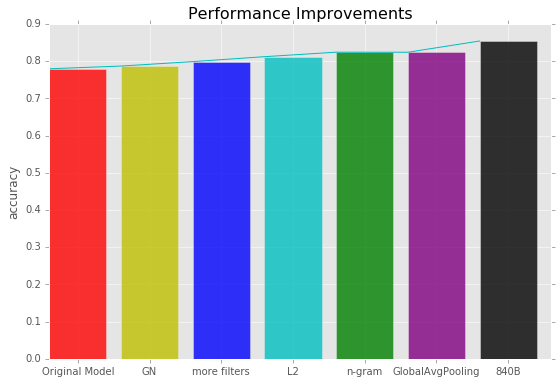

In [30]:
plt.style.use("ggplot")

fig = plt.figure(figsize = (9,6))
labels = ['Original Model','GN','more filters','L2','n-gram','GlobalAvgPooling','840B']
colors = ['r','y','b','c','g','purple','k']

for i in range(7):
    plt.bar(x_value[i],y_value[i],color = colors[i],alpha = 0.8)

plt.plot(x_value,y_value,color = 'c')
plt.title("Performance Improvements",fontsize = 16)
plt.xticks([0.4,1.4,2.4,3.4,4.4,5.4,6.4],labels)#
plt.ylabel('accuracy')